* 隠れ状態をカウントにして全データを使って学習したHMM

In [4]:
import pandas as pd
df=pd.read_csv("statcast_data_pitch_categori.csv")
pd.set_option('display.max_columns', None)  # カラムの表示制限を解除
pd.set_option('display.width', 1000)        # 横幅も広げる（必要なら）
print(df.head(200))

     Unnamed: 0 pitch_type   game_date  release_speed  release_pos_x  release_pos_z    player_name  batter  pitcher     events    description  zone                                                des game_type stand p_throws home_team away_team type  hit_location      bb_type  balls  strikes  game_year  pfx_x  pfx_z  plate_x  plate_z  on_3b  on_2b  on_1b  outs_when_up  inning inning_topbot    hc_x    hc_y        vx0         vy0       vz0         ax         ay         az  sz_top  sz_bot  hit_distance_sc  launch_speed  launch_angle  effective_speed  release_spin_rate  release_extension  game_pk  fielder_2  fielder_3  fielder_4  fielder_5  fielder_6  fielder_7  fielder_8  fielder_9  release_pos_y  estimated_ba_using_speedangle  estimated_woba_using_speedangle  woba_value  woba_denom  babip_value  iso_value  launch_speed_angle  at_bat_number  pitch_number       pitch_name  home_score  away_score  bat_score  fld_score  post_away_score  post_home_score  post_bat_score  post_fld_score  \
0    

In [2]:
df["home_score_diff"]

0          0
1          0
2          0
3          0
4          0
          ..
3345234   -1
3345235   -1
3345236   -1
3345237   -1
3345238   -1
Name: home_score_diff, Length: 3345239, dtype: int64

In [7]:
# カテゴリを整数に変換
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [8]:
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import CategoricalHMM
from hmmlearn.hmm import GaussianHMM
import numpy as np
from sklearn.model_selection import train_test_split
from hmmlearn.hmm import CategoricalHMM

In [5]:
df['runner_str'] = (
        df['on_1b'].notnull().astype(int).astype(str) +
        df['on_2b'].notnull().astype(int).astype(str) +
        df['on_3b'].notnull().astype(int).astype(str)
    )

In [9]:
df = df[(df["balls"] <= 3) & (df["strikes"] <= 2)]


In [10]:
from sklearn.preprocessing import LabelEncoder

# --- 観測値（球種 + zone）を文字列にしてエンコード ---
df = df[df["zone"].notnull()] 
df = df[df["pitch_cluster_label"].notnull()]
df["pitch_obs"] = df["pitch_cluster_label"] + "_" + df["zone"].astype(str)

obs_encoder = LabelEncoder()
df["obs_encoded"] = obs_encoder.fit_transform(df["pitch_obs"])

# --- 状況を構成するカラムをまとめて文字列化してエンコード ---
#situation_cols = [
    #"runner_str",     # ランナー状況: '000', '100' など
    #"balls",
    #"strikes",
    #"outs_when_up",            # カウント: '3-2', '0-1' など       # 点差: 整数（例: -1, 0, 3）
    #"stand",      # バッターの利き手: 'L' or 'R'
    #"p_throws",     # ピッチャーの利き手: 'L' or 'R          # ピッチャーID（数値）            # イニング番号: 整数
#]
# 例えば balls+strikes をまとめて count
df["count_str"] = df["balls"].astype(str) + "-" + df["strikes"].astype(str)+"-"+df["outs_when_up"].astype(str)
# これを count_encoded にして使う

#df["situation_str"] = df[situation_cols].astype(str).agg("_".join, axis=1)

situation_encoder = LabelEncoder()
df["situation_encoded"] = situation_encoder.fit_transform(df["count_str"])


In [8]:
#print(situation_encoder.classes_[:5])

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
#import ace_tools as tools

# ピッチャー単位で train/test に分割し、split カラムを追加
df["split"] = "none"
for pid, pitcher_df in df.groupby("pitcher"):
    games = pitcher_df["game_pk"].unique()
    if pitcher_df.shape[0] < 10 or len(games) < 2:
        continue

    train_games, test_games = train_test_split(games, test_size=0.3, shuffle=False, random_state=42)

    df.loc[(df["pitcher"] == pid) & (df["game_pk"].isin(train_games)), "split"] = "train"
    df.loc[(df["pitcher"] == pid) & (df["game_pk"].isin(test_games)), "split"] = "test"

# 教師ありHMMの数え上げ学習（trainデータのみ）

n_states = df["situation_encoded"].nunique()
n_obs = df["obs_encoded"].nunique()

pi = np.zeros(n_states)
A = np.zeros((n_states, n_states))
B = np.zeros((n_states, n_obs))

train_df = df[df["split"] == "train"]

for (pid, game), group in train_df.groupby(["pitcher", "game_pk"]):
    states = group["situation_encoded"].values
    obs = group["obs_encoded"].values

    if len(states) < 2:
        continue

    pi[states[0]] += 1

    for i in range(1, len(states)):
        A[states[i - 1], states[i]] += 1

    for s, o in zip(states, obs):
        B[s, o] += 1

# 安全な正規化処理
pi /= pi.sum()

A_row_sums = A.sum(axis=1, keepdims=True)
A = np.divide(A, A_row_sums, where=A_row_sums != 0)

B_row_sums = B.sum(axis=1, keepdims=True)
B = np.divide(B, B_row_sums, where=B_row_sums != 0)

import pandas as pd
pi_df = pd.DataFrame(pi, columns=["pi"])
A_df = pd.DataFrame(A)
B_df = pd.DataFrame(B)

# 初期状態確率 pi
print("▼ 初期状態確率 π")
print(pi)

# 状態遷移確率 A（先頭5行だけ表示）
print("\n▼ 状態遷移確率 A（先頭5状態）")
print(pd.DataFrame(A).head())

# 出力確率 B（先頭5行だけ表示）
print("\n▼ 出力確率 B（先頭5状態）")
print(pd.DataFrame(B).head())



▼ 初期状態確率 π
[8.02717141e-01 8.64842343e-02 1.05307799e-01 4.76169219e-04
 2.52964897e-04 2.23204321e-04 7.44014404e-05 1.48802881e-05
 2.97605762e-05 1.53266967e-03 4.16648066e-04 4.61288931e-04
 1.19042305e-04 5.95211523e-05 1.19042305e-04 7.44014404e-05
 1.04162017e-04 8.92817285e-05 8.92817285e-05 1.19042305e-04
 1.19042305e-04 5.95211523e-05 7.44014404e-05 7.44014404e-05
 5.95211523e-05 5.95211523e-05 1.19042305e-04 7.44014404e-05
 2.97605762e-05 1.04162017e-04 5.95211523e-05 5.95211523e-05
 2.97605762e-05 1.04162017e-04 7.44014404e-05 1.33922593e-04]

▼ 状態遷移確率 A（先頭5状態）
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15        16   17        18        19        20        21        22   23   24   25   26   27        28   29   30   31   32   33   34   35
0  0.039289  0.065865  0.004048  0.510687  0.000420  0.000000  0.000015  0.000000  0.000000  0.379181  0.000355  0.000000  

In [30]:
import matplotlib.font_manager as fm
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties

# 日本語対応フォント候補を抽出して表示
for font in fm.findSystemFonts(fontpaths=None, fontext='ttf'):
    if any(x in font.lower() for x in ['gothic', 'meiryo', 'noto', 'ipa', 'takao']):
        print(font)
# 日本語フォント設定
jp_font = FontProperties(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc')
rcParams['font.family'] = jp_font.get_name()
rcParams['axes.unicode_minus'] = False  # マイナス記号の文字化け対策

/usr/share/fonts/opentype/noto/NotoSerifCJK-ExtraLight.ttc
/usr/share/fonts/opentype/ipafont-gothic/ipagp.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc
/usr/share/fonts/truetype/fonts-japanese-gothic.ttf
/usr/share/fonts/truetype/takao-gothic/TakaoPGothic.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Black.ttc
/usr/share/fonts/truetype/noto/NotoSansMono-Regular.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Bold.ttc
/usr/share/fonts/opentype/ipafont-mincho/ipamp.ttf
/usr/share/fonts/truetype/takao-mincho/TakaoMincho.ttf
/usr/share/fonts/opentype/noto/NotoSansCJK-Black.ttc
/usr/share/fonts/opentype/noto/NotoSansCJK-DemiLight.ttc
/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Light.ttc
/usr/share/fonts/meiryo/meiryob.ttc
/usr/share/fonts/opentype/ipafont-mincho/ipam.ttf
/usr/share/fonts/truetype/takao-gothic/TakaoGothic.ttf
/usr/share/fonts/opentype/noto/NotoSerifCJK-Medium.ttc
/usr/share/fonts/opentype/urw-base35/URWGothic-Bo

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# pi の可視化（棒グラフ）
def plot_initial_probabilities(pi, state_labels=None):
    plt.figure(figsize=(16, 5))

    x = range(len(pi))
    labels = state_labels if state_labels is not None else x

    plt.bar(x, pi, color="steelblue")
    plt.xticks(ticks=x, labels=labels, rotation=90, fontsize=10)
    plt.xlabel("State")
    plt.ylabel("初期状態 (π)")
    plt.title("初期状態確率(π)")
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


# A の可視化（ヒートマップ）
def plot_transition_matrix(A_df):
    plt.figure(figsize=(10, 8))
    sns.heatmap(A_df,xticklabels=situation_encoder.classes_,yticklabels=situation_encoder.classes_ ,cmap="YlGnBu", cbar=True)
    plt.title("遷移確立 (A)")
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.tight_layout()
    plt.show()

# B の可視化（ヒートマップ）
#short_obs_labels = [label.replace("_", "") for label in obs_encoder.classes_]
#short_state_labels = [label.replace("-", "") for label in situation_encoder.classes_]

short_obs_labels = [
    str(label).replace("_", "") if isinstance(label, str) else str(label)
    for label in obs_encoder.classes_
]

short_state_labels = [
    str(label).replace("-", "") if isinstance(label, str) else str(label)
    for label in situation_encoder.classes_
]
def plot_emission_matrix(B_df):
    plt.figure(figsize=(18, 10))
    ax = sns.heatmap(B_df, xticklabels=short_obs_labels, yticklabels=short_state_labels, cmap="YlGnBu", cbar=True)
    plt.title("出力確率(B)")
    plt.xlabel("Observation")
    plt.ylabel("State")

    # ラベル間引きと回転
    #ax.set_xticks(np.arange(0, len(short_obs_labels), 10))
    #ax.set_xticklabels(short_obs_labels[::10], rotation=90)

    plt.tight_layout()
    plt.show()


In [12]:
print("pi:", len(pi))
print("state_labels:", len(short_state_labels))


pi: 36
state_labels: 36


In [13]:
print(short_state_labels)


['000', '001', '002', '010', '011', '012', '020', '021', '022', '100', '101', '102', '110', '111', '112', '120', '121', '122', '200', '201', '202', '210', '211', '212', '220', '221', '222', '300', '301', '302', '310', '311', '312', '320', '321', '322']


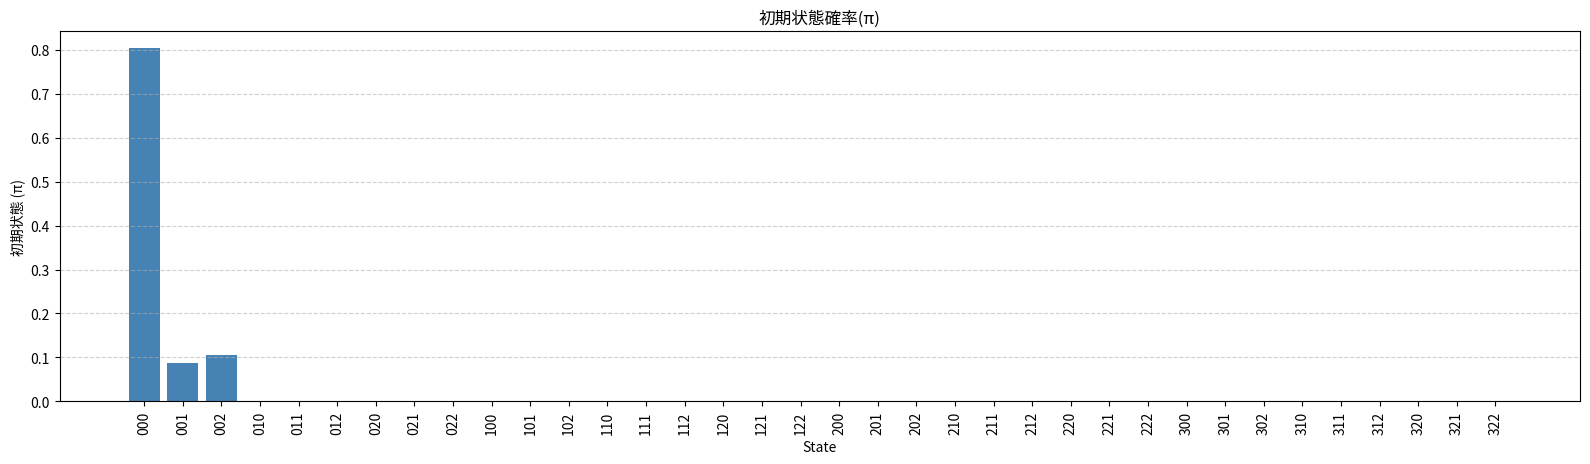

In [14]:
plot_initial_probabilities(pi,state_labels=short_state_labels)


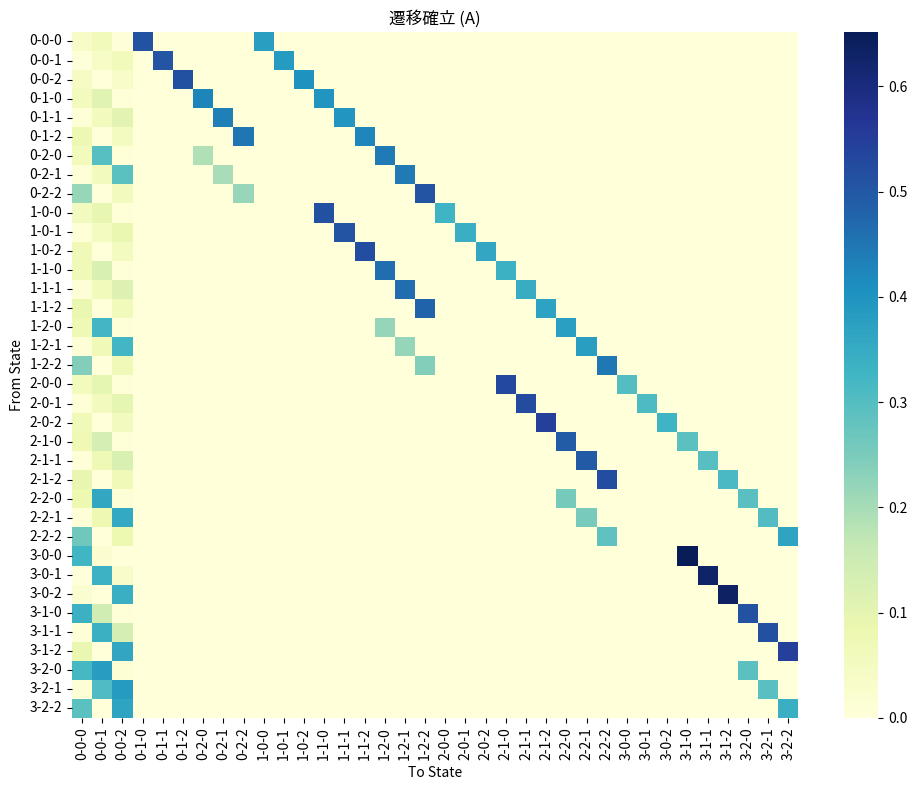

In [15]:
plot_transition_matrix(A_df)

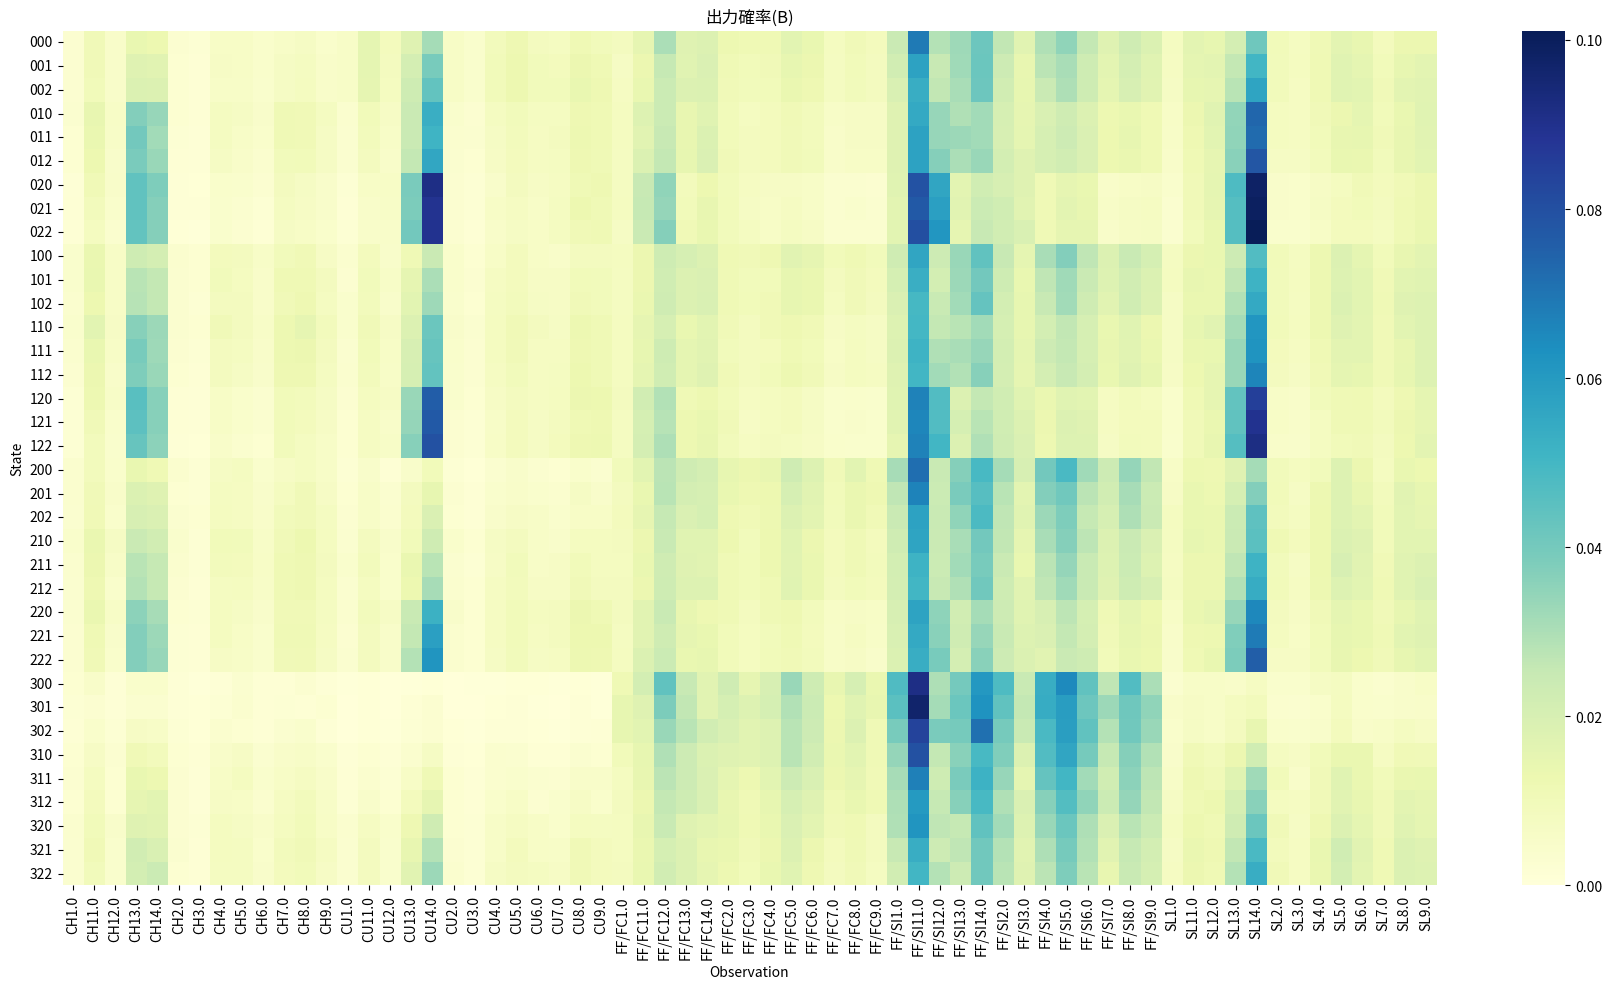

In [16]:
plot_emission_matrix(B_df)

In [17]:
import numpy as np

# Viterbiアルゴリズム関数（再掲）
def viterbi(obs_seq, pi, A, B):
    n_states = A.shape[0]
    T = len(obs_seq)
    delta = np.zeros((T, n_states))
    psi = np.zeros((T, n_states), dtype=int)
    
    delta[0] = pi * B[:, obs_seq[0]]
    psi[0] = 0
    
    for t in range(1, T):
        for j in range(n_states):
            delta_t = delta[t - 1] * A[:, j]
            #prob = delta[t - 1] * A[:, j] * B[j, obs_seq[t]]
            psi[t, j] = np.argmax(delta_t)
            delta[t, j] = np.max(delta_t)* B[j, obs_seq[t]]
    
    path = np.zeros(T, dtype=int)
    path[-1] = np.argmax(delta[-1])
    for t in reversed(range(1, T)):
        path[t - 1] = psi[t, path[t]]
    
    return path

# 精度計算（正解との比較）
all_preds = []
all_true = []

for (pid, game), group in df.groupby(["pitcher", "game_pk"]):
    states = group["situation_encoded"].values
    obs = group["obs_encoded"].values

    if len(states) < 2:
        continue

    pred = viterbi(obs, pi, A, B)
    all_preds.extend(pred)
    all_true.extend(states[:len(pred)])  # 予測と長さを合わせる

# 正解率の計算
accuracy = np.mean(np.array(all_preds) == np.array(all_true))
accuracy


0.10726802233491423

In [18]:
all_preds = []
all_true = []

test_df = df[df["split"] == "test"]

for (pid, game), group in test_df.groupby(["pitcher", "game_pk"]):
    states = group["situation_encoded"].values
    obs = group["obs_encoded"].values

    if len(states) < 1:
        continue

    # 状況（隠れ状態）から観測値を予測（最も確率が高いもの）
    for s, true_o in zip(states, obs):
        pred_o = B[s].argmax()  # 出力確率が最大の観測値
        all_preds.append(pred_o)
        all_true.append(true_o)

# 精度計算
accuracy = np.mean(np.array(all_preds) == np.array(all_true))
print(f"配球予測の正解率: {accuracy:.4f}")


配球予測の正解率: 0.0685


In [19]:
# すでにあなたのコードでやってる！→ B = 出力確率
B_true = B  # shape = [n_states, n_obs]


In [20]:
from hmmlearn.hmm import MultinomialHMM
#X_train = train_df["obs_encoded"].values.reshape(-1, 1)
#X_train = df[df["split"] == "train"]["obs_encoded"].astype(int).values.reshape(-1, 1)
X_train = df[df["split"] == "train"]["obs_encoded"].values.astype(int).reshape(-1, 1)

lengths_train = train_df.groupby(["pitcher", "game_pk"]).size().values.astype(int)

# テスト用（あとで評価に使う）
#X_test = test_df["obs_encoded"].values.reshape(-1, 1)
X_test = df[df["split"] == "test"]["obs_encoded"].astype(int).values.reshape(-1, 1)
lengths_test = test_df.groupby(["pitcher", "game_pk"]).size().values.astype(int)


In [21]:
print("X_train.shape:", X_train.shape)
print("X_train[:10].T:", X_train[:10].T)  # 転置して見やすく
print("dtype:", X_train.dtype)


X_train.shape: (2266146, 1)
X_train[:10].T: [[40 40 51 23 47 42 62 46 60 41]]
dtype: int64


In [22]:
print("obs_encoded最大値:", df["obs_encoded"].max())
print("obs_encodedユニーク数:", df["obs_encoded"].nunique())


obs_encoded最大値: 64
obs_encodedユニーク数: 65


In [23]:
print(n_obs)

65


In [24]:
model = CategoricalHMM(n_components=n_states, n_iter=100,n_features=n_obs,verbose=True)
#model.n_features = n_obs
model.fit(X_train, lengths=lengths_train)
B_pred = model.emissionprob_  # shape = [n_states, n_obs]


         1 -9510259.12031273             +nan
         2 -8882512.07880241 +627747.04151032
         3 -8866029.52710464  +16482.55169777
         4 -8832201.45015736  +33828.07694728
         5 -8757151.18448696  +75050.26567040
         6 -8637372.65004276 +119778.53444420
         7 -8525051.20088635 +112321.44915641
         8 -8465160.51596627  +59890.68492008
         9 -8440981.39968734  +24179.11627893
        10 -8427671.32190236  +13310.07778498
        11 -8417569.35207700  +10101.96982536
        12 -8409260.37624636   +8308.97583064
        13 -8402261.80022963   +6998.57601673
        14 -8396144.54105478   +6117.25917485
        15 -8390569.90558658   +5574.63546820
        16 -8385369.76298494   +5200.14260164
        17 -8380526.58993685   +4843.17304809
        18 -8376095.65961496   +4430.93032190
        19 -8372127.88004137   +3967.77957359
        20 -8368627.54257620   +3500.33746516
        21 -8365554.08476448   +3073.45781173
        22 -8362844.83849003   +27

In [25]:
import pickle

# 保存
with open('trained_hmm.pkl', 'wb') as f:
    pickle.dump(model, f)


In [1]:
import pickle

# 読み込み
with open('trained_hmm.pkl', 'rb') as f:
    loaded_model = pickle.load(f)


In [16]:
all_preds_loaded = []
all_true_loaded = []

# dfをtestだけに絞る
test_df = df[df["split"] == "test"]

for (pid, game), group in test_df.groupby(["pitcher", "game_pk"]):
    states = group["situation_encoded"].values
    obs = group["obs_encoded"].values

    if len(states) < 2:
        continue

    pred = loaded_model.predict(obs.reshape(-1, 1))  # predictは2次元期待
    all_preds_loaded.extend(pred)
    all_true_loaded.extend(states[:len(pred)])


In [34]:
import numpy as np

# 予測から球種×コースを復元するリスト
predicted_obs_from_state = []

# 各隠れ状態について、最も確率が高い観測値を選ぶ
most_likely_obs = np.argmax(B_pred, axis=1)  # (n_states, )

for pred_state in all_preds_loaded:
    obs_idx = most_likely_obs[pred_state]  # 予測された状態に対応する観測値インデックス
    predicted_obs_from_state.append(obs_idx)

# obs_encoderを使って観測値のラベルに戻す（もし必要なら）
predicted_obs_labels = obs_encoder.inverse_transform(predicted_obs_from_state)


In [ ]:
import numpy as np

# ① 予測された隠れ状態から、最も確率が高い観測値を取り出す
most_likely_obs = np.argmax(B_pred, axis=1)  # (n_states, )

predicted_obs_from_state = []
for pred_state in all_preds_loaded:
    obs_idx = most_likely_obs[pred_state]
    predicted_obs_from_state.append(obs_idx)

# ② 観測ラベルに戻す
predicted_obs_labels = obs_encoder.inverse_transform(predicted_obs_from_state)
true_obs_labels = obs_encoder.inverse_transform(all_true_loaded)

# ③ 完全一致正解率
correct = np.sum(predicted_obs_labels == true_obs_labels)
accuracy = correct / len(true_obs_labels)
print(f"完全一致正解率: {accuracy:.4f}")

# ④ ゆるい正解率（zoneが近いならOK）
def is_similar(pred_label, true_label):
    # 例："fastball_1" → ["fastball", "1"]
    pred_pitch, pred_zone = pred_label.rsplit("_", 1)
    true_pitch, true_zone = true_label.rsplit("_", 1)
    
    # 球種が同じかつ、zoneが近いならOK（±1まで許す）
    if pred_pitch == true_pitch:
        if abs(int(float(pred_zone)) - int(float(true_zone))) <= 1:
            return True
    return False

similar_correct = sum(is_similar(p, t) for p, t in zip(predicted_obs_labels, true_obs_labels))
similar_accuracy = similar_correct / len(true_obs_labels)
print(f"ゆるい正解率（zone±1許容）: {similar_accuracy:.4f}")


完全一致正解率: 0.0109
ゆるい正解率（zone±1許容）: 0.0248


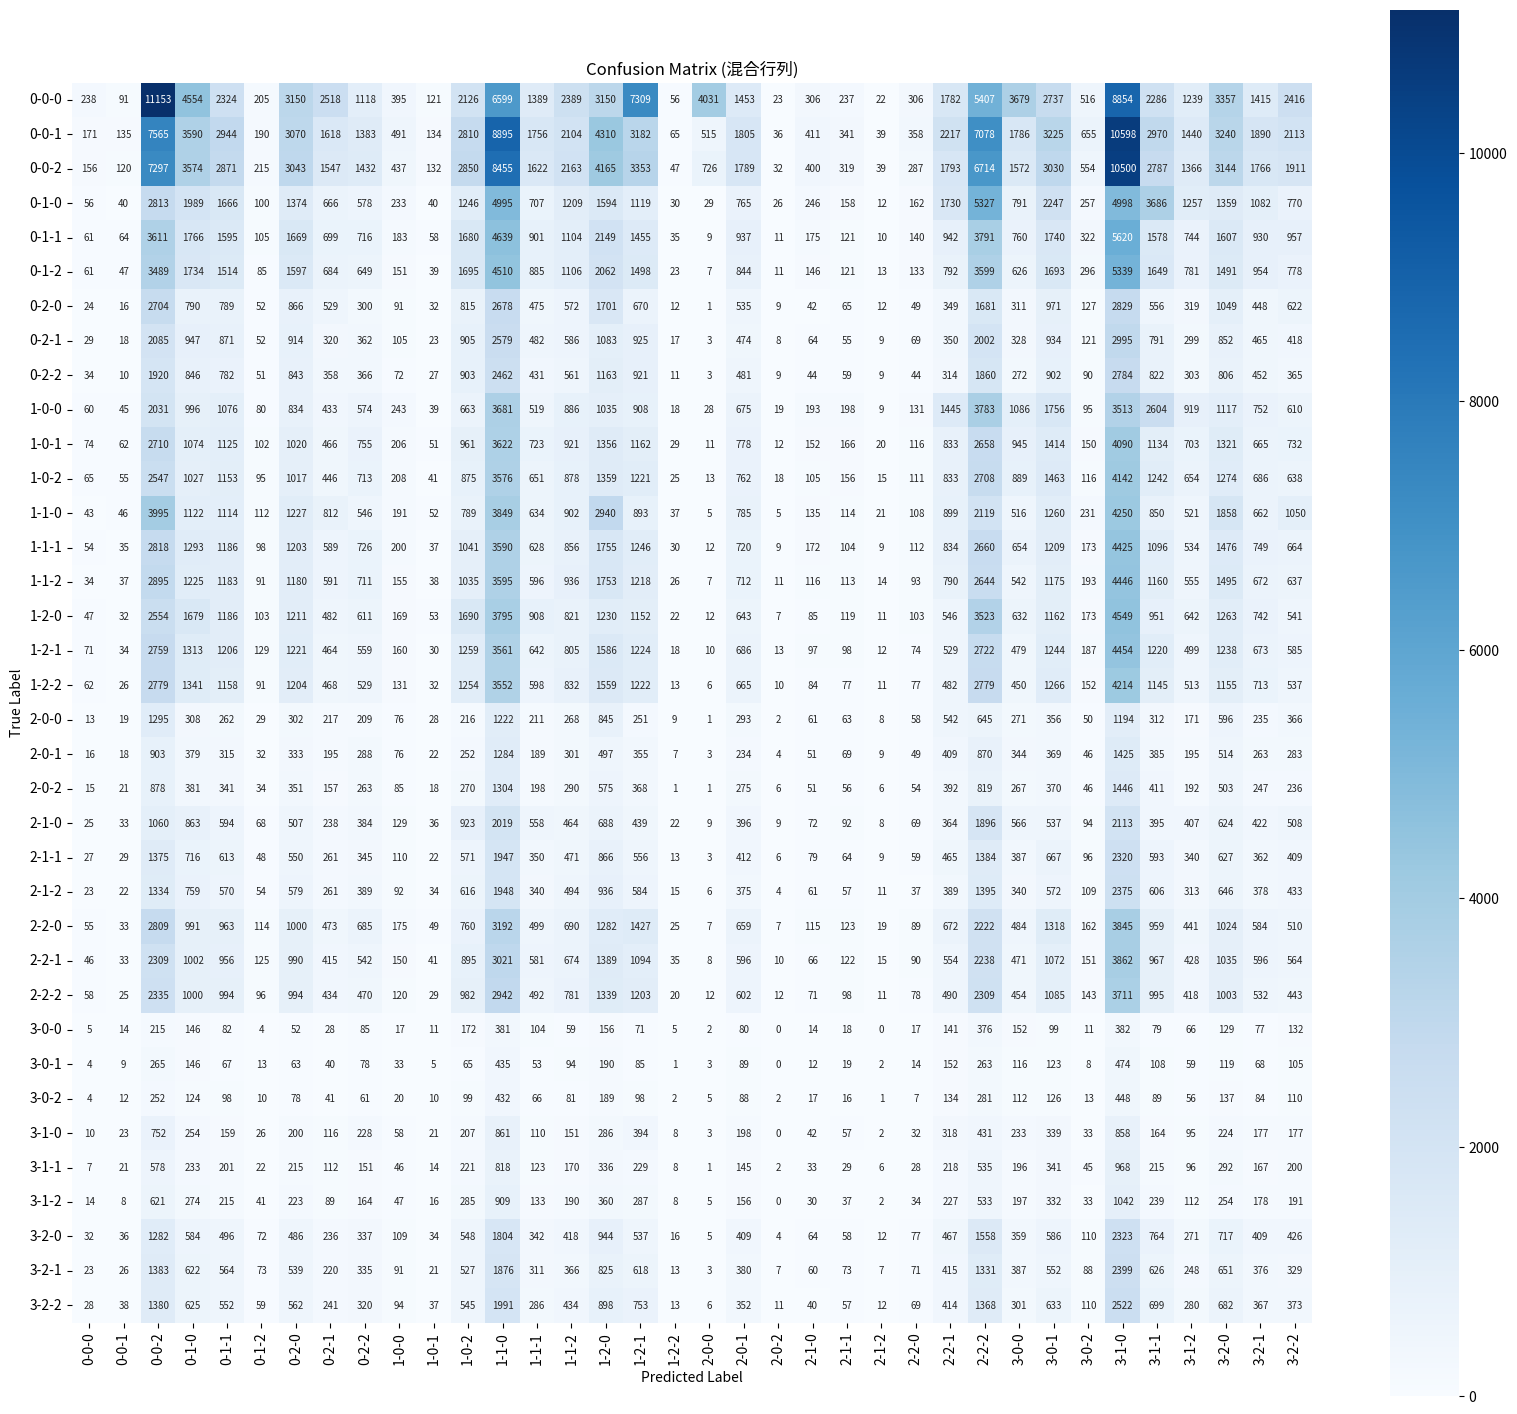

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix を作成
cm = confusion_matrix(all_true_loaded, all_preds_loaded, labels=range(n_states))

# ラベルを本来のcount_strに戻す
state_labels = situation_encoder.inverse_transform(np.arange(n_states))

# サイズ大きめで
plt.figure(figsize=(20, 18))
sns.heatmap(cm, cmap='Blues', square=True, cbar=True, annot=True, fmt='d', 
            xticklabels=state_labels, yticklabels=state_labels, annot_kws={"size":7})

plt.title("Confusion Matrix (混合行列)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=90)  # 横ラベル回転させた方が見やすい
plt.yticks(rotation=0)   # 縦ラベルはそのまま
plt.show()


In [19]:
import numpy as np

accuracy_loaded = np.mean(np.array(all_preds_loaded) == np.array(all_true_loaded))
print(f"正解率 (Loaded HMM model): {accuracy_loaded:.4f}")


正解率 (Loaded HMM model): 0.0283


In [20]:
# 元のラベルに逆変換
true_labels = situation_encoder.inverse_transform(all_true_loaded)
pred_labels = situation_encoder.inverse_transform(all_preds_loaded)

# 似てるかどうか判定する関数
def is_similar(true_label, pred_label):
    t_balls, t_strikes, t_outs = map(int, true_label.split('-'))
    p_balls, p_strikes, p_outs = map(int, pred_label.split('-'))
    
    # balls, strikes, outs それぞれの差を見る
    diff = abs(t_balls - p_balls) + abs(t_strikes - p_strikes) + abs(t_outs - p_outs)
    
    # 差の合計が1以内なら似てるとみなす
    return diff <= 1

# ゆるい正解率計算
similar_correct = sum(is_similar(t, p) for t, p in zip(true_labels, pred_labels))
similar_accuracy = similar_correct / len(true_labels)

print(f"ゆるい正解率: {similar_accuracy:.4f}")


ゆるい正解率: 0.1404


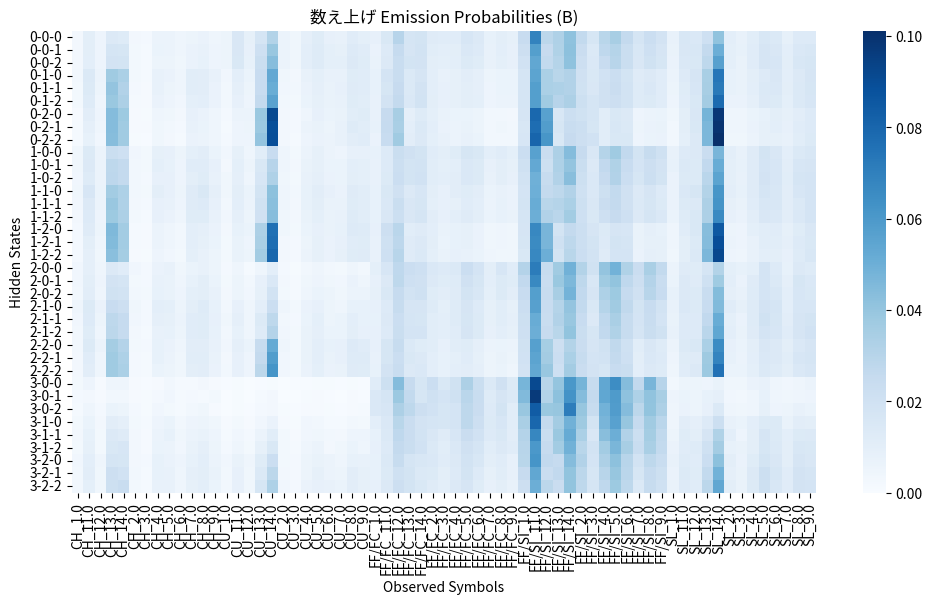

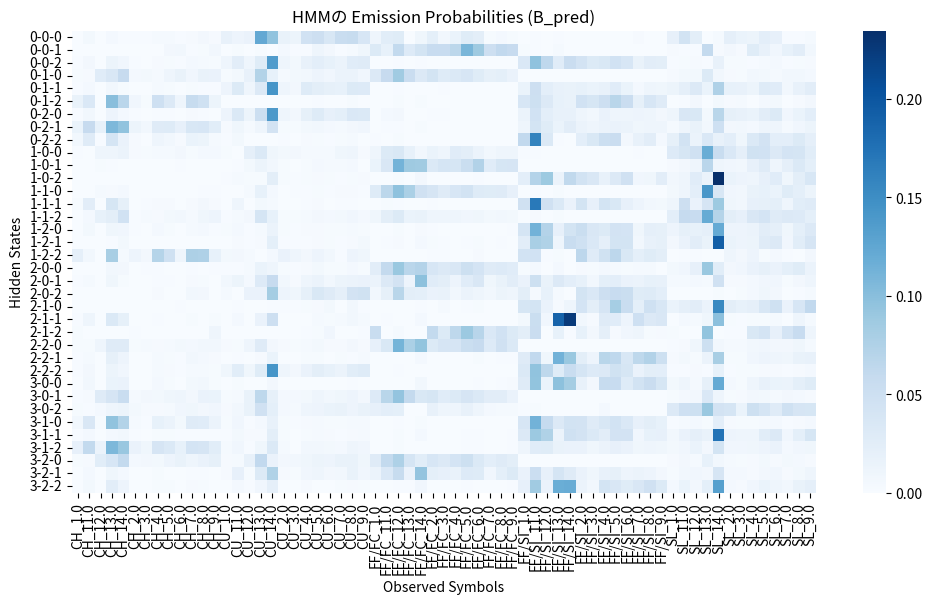

In [32]:
import seaborn as sns
# 読み込んだHMMから出力確率を取り出す
B_pred = loaded_model.emissionprob_
# 観測値のラベルを復元
obs_labels = obs_encoder.inverse_transform(np.arange(B.shape[1]))

# 頻度ベースB
plt.figure(figsize=(12, 6))
sns.heatmap(B, cmap="Blues",xticklabels=obs_labels,yticklabels=state_labels)
plt.title("数え上げ Emission Probabilities (B)")
plt.xlabel("Observed Symbols")
plt.ylabel("Hidden States")
plt.show()

# 学習後B_pred
plt.figure(figsize=(12, 6))
sns.heatmap(B_pred, cmap="Blues",xticklabels=obs_labels,yticklabels=state_labels)
plt.title("HMMの Emission Probabilities (B_pred)")
plt.xlabel("Observed Symbols")
plt.ylabel("Hidden States")
plt.show()


In [33]:
from scipy.special import rel_entr  # KLダイバージェンス用

kl_list = []

# testデータだけ使う
test_df = df[df["split"] == "test"]

for pid, group in test_df.groupby("pitcher"):
    obs_counts = group["obs_encoded"].value_counts().reindex(range(B.shape[1]), fill_value=0)
    
    # 実際の観測確率（頻度ベース）
    p_true = obs_counts.values / obs_counts.values.sum()
    
    # モデル推定確率（学習したモデルで推定）
    # 推定には、そのピッチャーの「隠れ状態」推定が必要
    try:
        pred_states = loaded_model.predict(group["obs_encoded"].values.reshape(-1, 1))
        # 推定された状態ごとに、B_predから観測確率を取り出す
        p_pred = B_pred[pred_states].mean(axis=0)  # 平均する
        
        # スムージング（0だとKLが無限大になるから、少しだけ足す）
        eps = 1e-8
        p_true = np.clip(p_true, eps, 1)
        p_pred = np.clip(p_pred, eps, 1)

        # KLダイバージェンス計算
        kl = np.sum(rel_entr(p_true, p_pred))
        kl_list.append(kl)

    except Exception as e:
        print(f"ピッチャー {pid} でエラー: {e}")
        continue

# 全ピッチャーのKLの平均
kl_mean = np.mean(kl_list)
print(f"全ピッチャーの平均KLダイバージェンス: {kl_mean:.6f}")


全ピッチャーの平均KLダイバージェンス: 0.424179


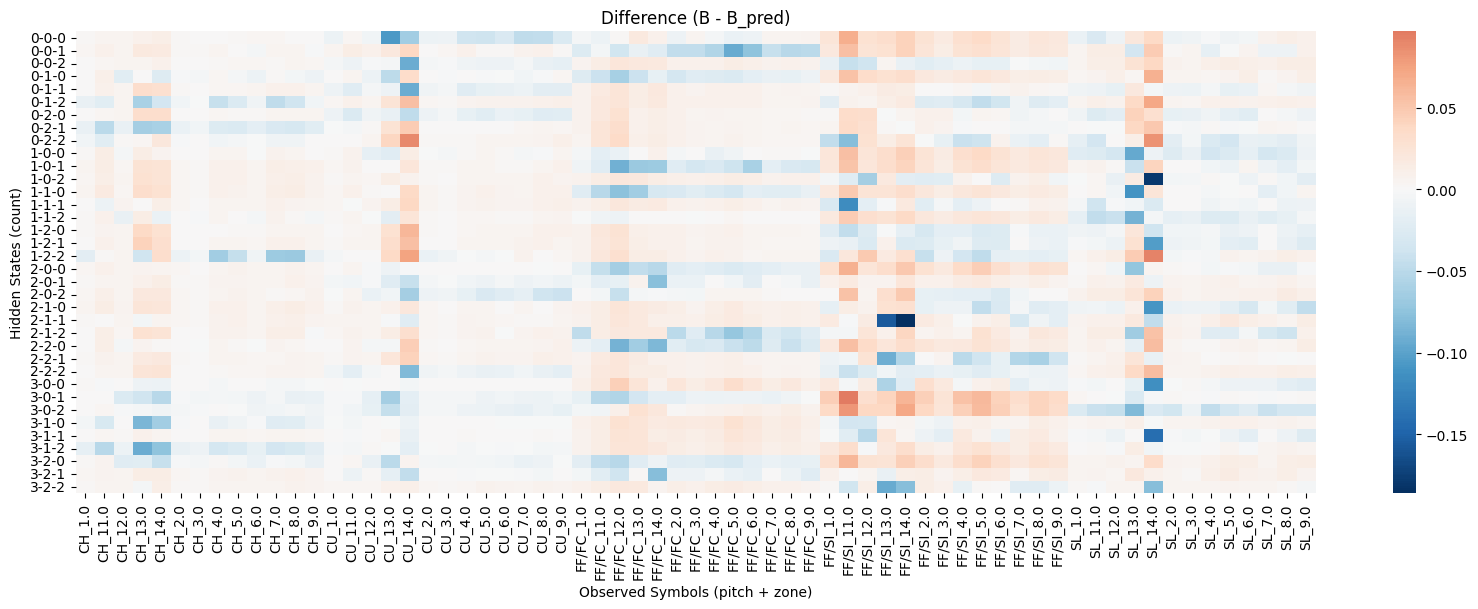

In [27]:
# 差分を計算
diff = B - B_pred

# 差分ヒートマップ
plt.figure(figsize=(20, 6))
sns.heatmap(diff, cmap="RdBu_r", center=0, xticklabels=obs_labels, yticklabels=state_labels)

plt.title("Difference (B - B_pred)")
plt.xlabel("Observed Symbols (pitch + zone)")
plt.ylabel("Hidden States (count)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


In [25]:
B_pred.shape

(36, 65)

In [26]:
# モデルが収束したか確認
print("収束した？:", model.monitor_.converged)
print("最終log-likelihood:", model.monitor_.history[-1])
print("総反復回数:", model.monitor_.iter)
print("B_pred.shape:", model.emissionprob_.shape)


収束した？: True
最終log-likelihood: -8285558.341821247
総反復回数: 100
B_pred.shape: (36, 65)


In [27]:
# 混合行列
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

true_states = test_df["situation_encoded"].values
_, pred_states = model.decode(X_test)

cm = confusion_matrix(true_states, pred_states)
row_ind, col_ind = linear_sum_assignment(-cm)

mapping = {pred: true for pred, true in zip(col_ind, row_ind)}
# 正解ラベル順に教師なしの状態インデックスを並べる
ordered_indices = [k for k, _ in sorted(mapping.items(), key=lambda x: x[1])]
B_pred_mapped = model.emissionprob_[ordered_indices, :]



In [28]:
print("B_pred.shape:", model.emissionprob_.shape)
print("ordered_indices[:5]:", ordered_indices[:5])
print("B_pred[ordered_indices[:5]].shape:", B_pred[ordered_indices[:5]].shape)


B_pred.shape: (36, 65)
ordered_indices[:5]: [30, 0, 16, 3, 35]
B_pred[ordered_indices[:5]].shape: (5, 65)


In [29]:
# 安全チェック
print("B_pred_mapped.shape:", B_pred_mapped.shape)
print("行ごとの和（≒1か）:", np.sum(B_pred_mapped, axis=1))
print("ユニーク値:", np.unique(B_pred_mapped))


B_pred_mapped.shape: (36, 65)
行ごとの和（≒1か）: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
ユニーク値: [3.75437174e-17 1.33902121e-15 5.05230425e-14 ... 2.56231813e-01
 2.88082384e-01 3.12505318e-01]


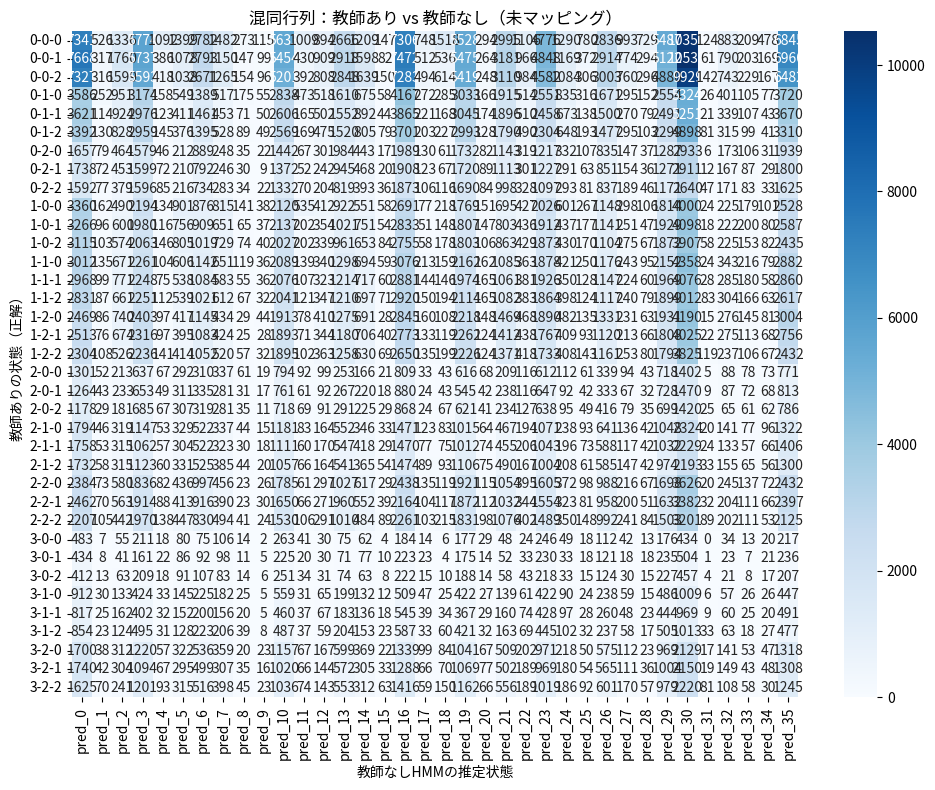

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 状態ラベル名の復元（教師あり）
true_labels = situation_encoder.inverse_transform(np.unique(true_states))
pred_labels = [f"pred_{i}" for i in np.unique(pred_states)]  # 推定状態は数値なのでprefixつける

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=pred_labels, yticklabels=true_labels)
plt.xlabel("教師なしHMMの推定状態")
plt.ylabel("教師ありの状態（正解）")
plt.title("混同行列：教師あり vs 教師なし（未マッピング）")
plt.tight_layout()
plt.show()


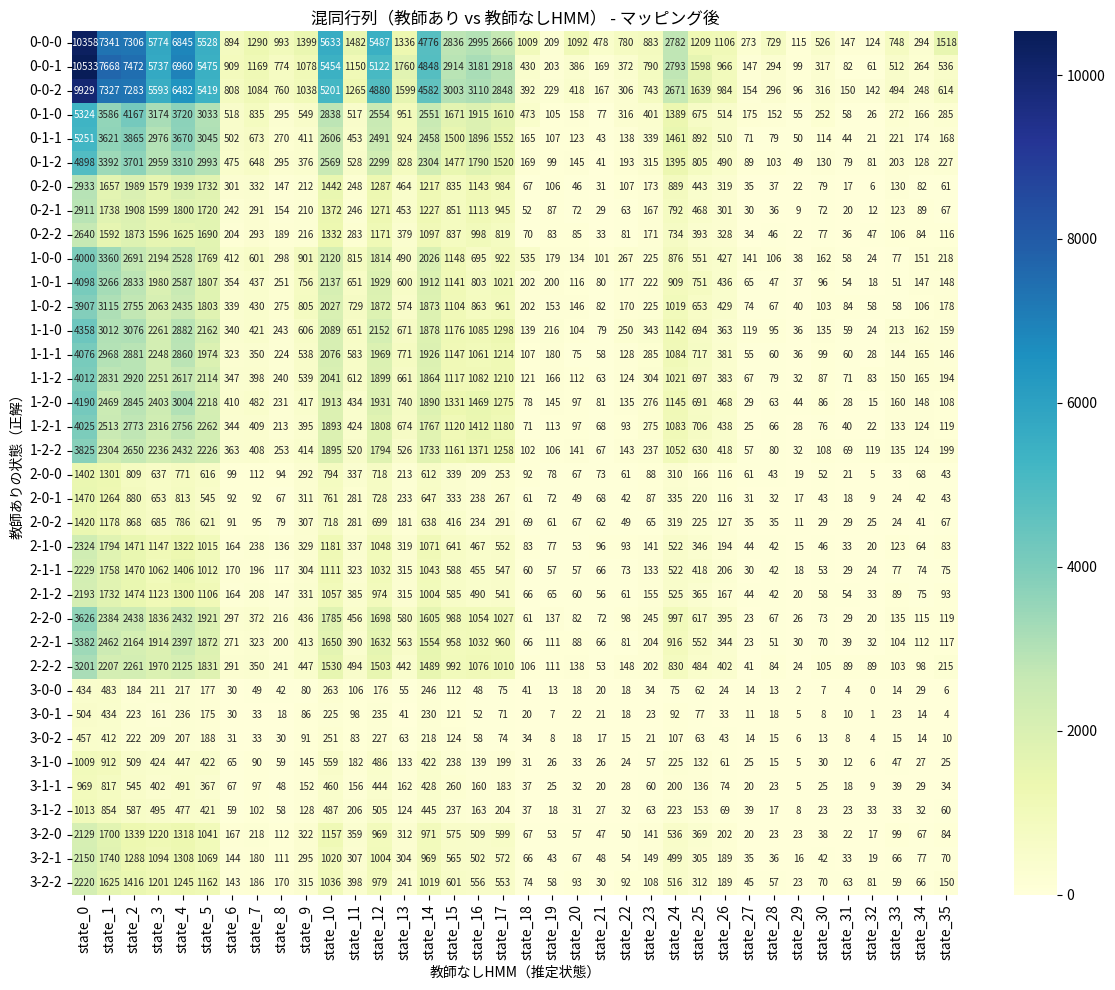

In [41]:
mapped_cm = cm[row_ind][:, col_ind]

plt.figure(figsize=(12, 10))
sns.heatmap(
    mapped_cm,
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=[f"state_{i}" for i in range(mapped_cm.shape[1])],
    yticklabels=[situation_encoder.inverse_transform([i])[0] for i in row_ind],
    annot_kws={"size": 7}
)
plt.title("混同行列（教師あり vs 教師なしHMM） - マッピング後")
plt.xlabel("教師なしHMM（推定状態）")
plt.ylabel("教師ありの状態（正解）")
plt.tight_layout()
plt.show()


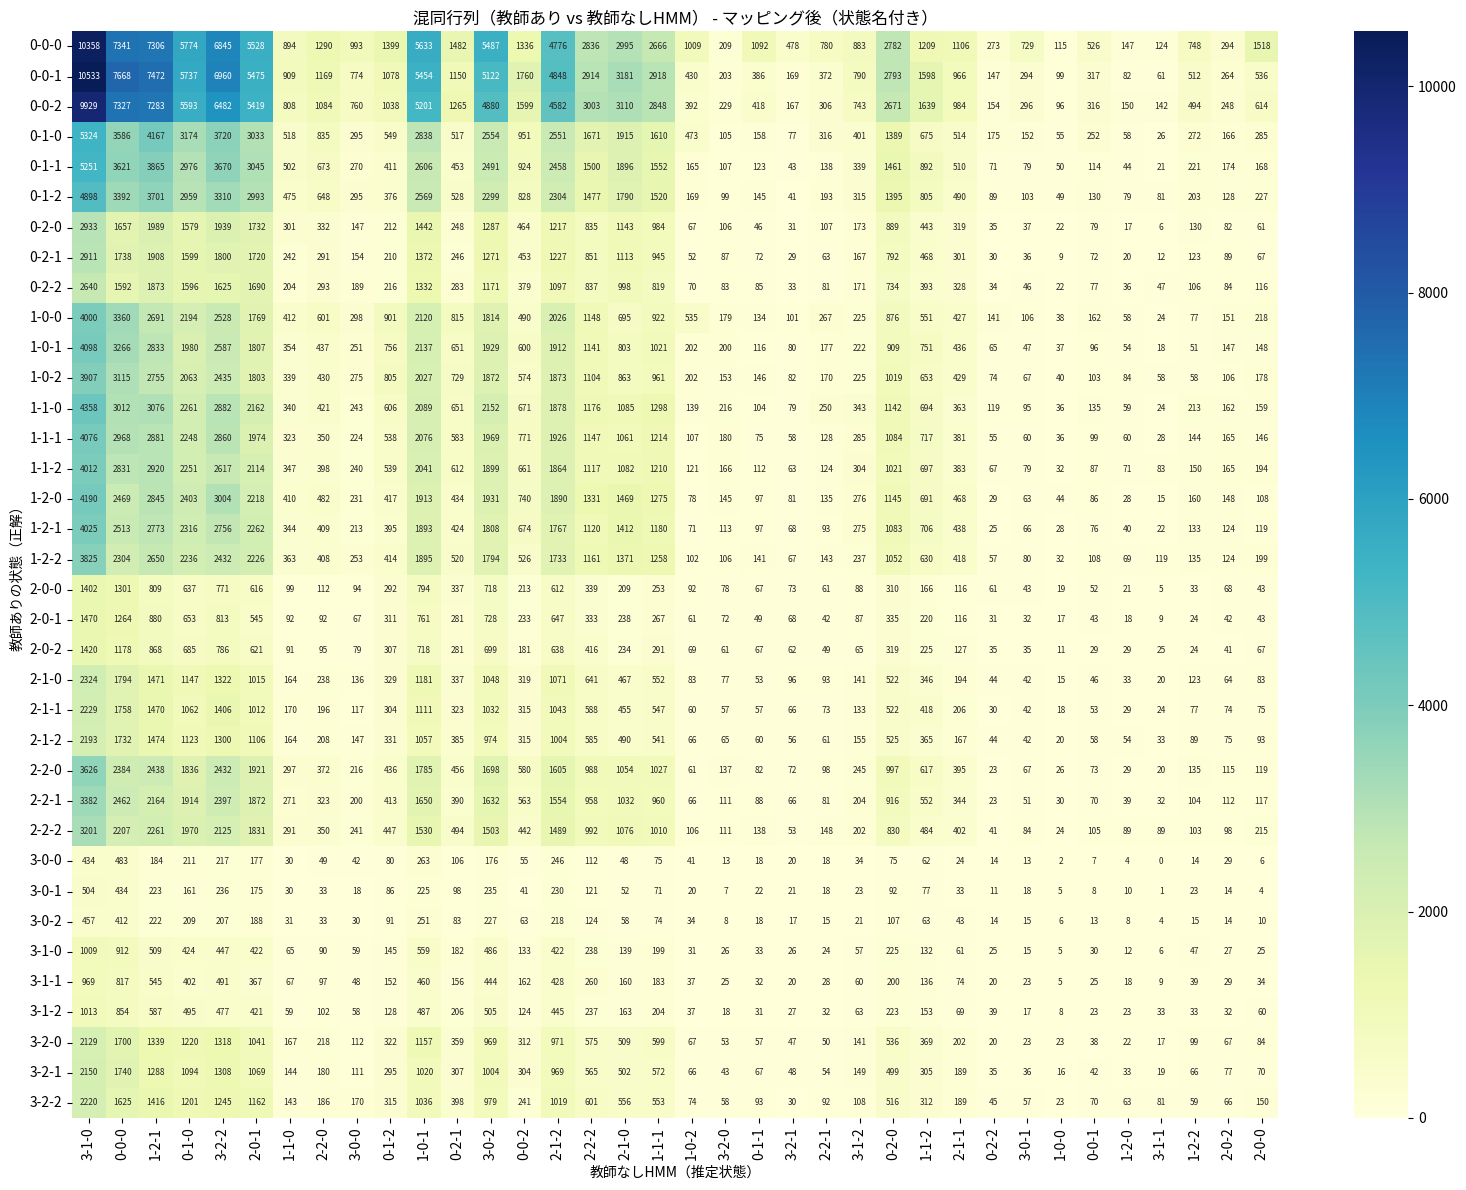

In [42]:
# マッピング後の教師なし状態インデックス（col_indに対応）
mapped_pred_labels = [situation_encoder.inverse_transform([i])[0] for i in col_ind]

plt.figure(figsize=(16, 12))
sns.heatmap(
    cm[row_ind][:, col_ind],
    annot=True,
    fmt="d",
    cmap="YlGnBu",
    xticklabels=mapped_pred_labels,
    yticklabels=[situation_encoder.inverse_transform([i])[0] for i in row_ind],
    annot_kws={"size": 6}
)
plt.xlabel("教師なしHMM（推定状態）")
plt.ylabel("教師ありの状態（正解）")
plt.title("混同行列（教師あり vs 教師なしHMM） - マッピング後（状態名付き）")
plt.tight_layout()
plt.show()


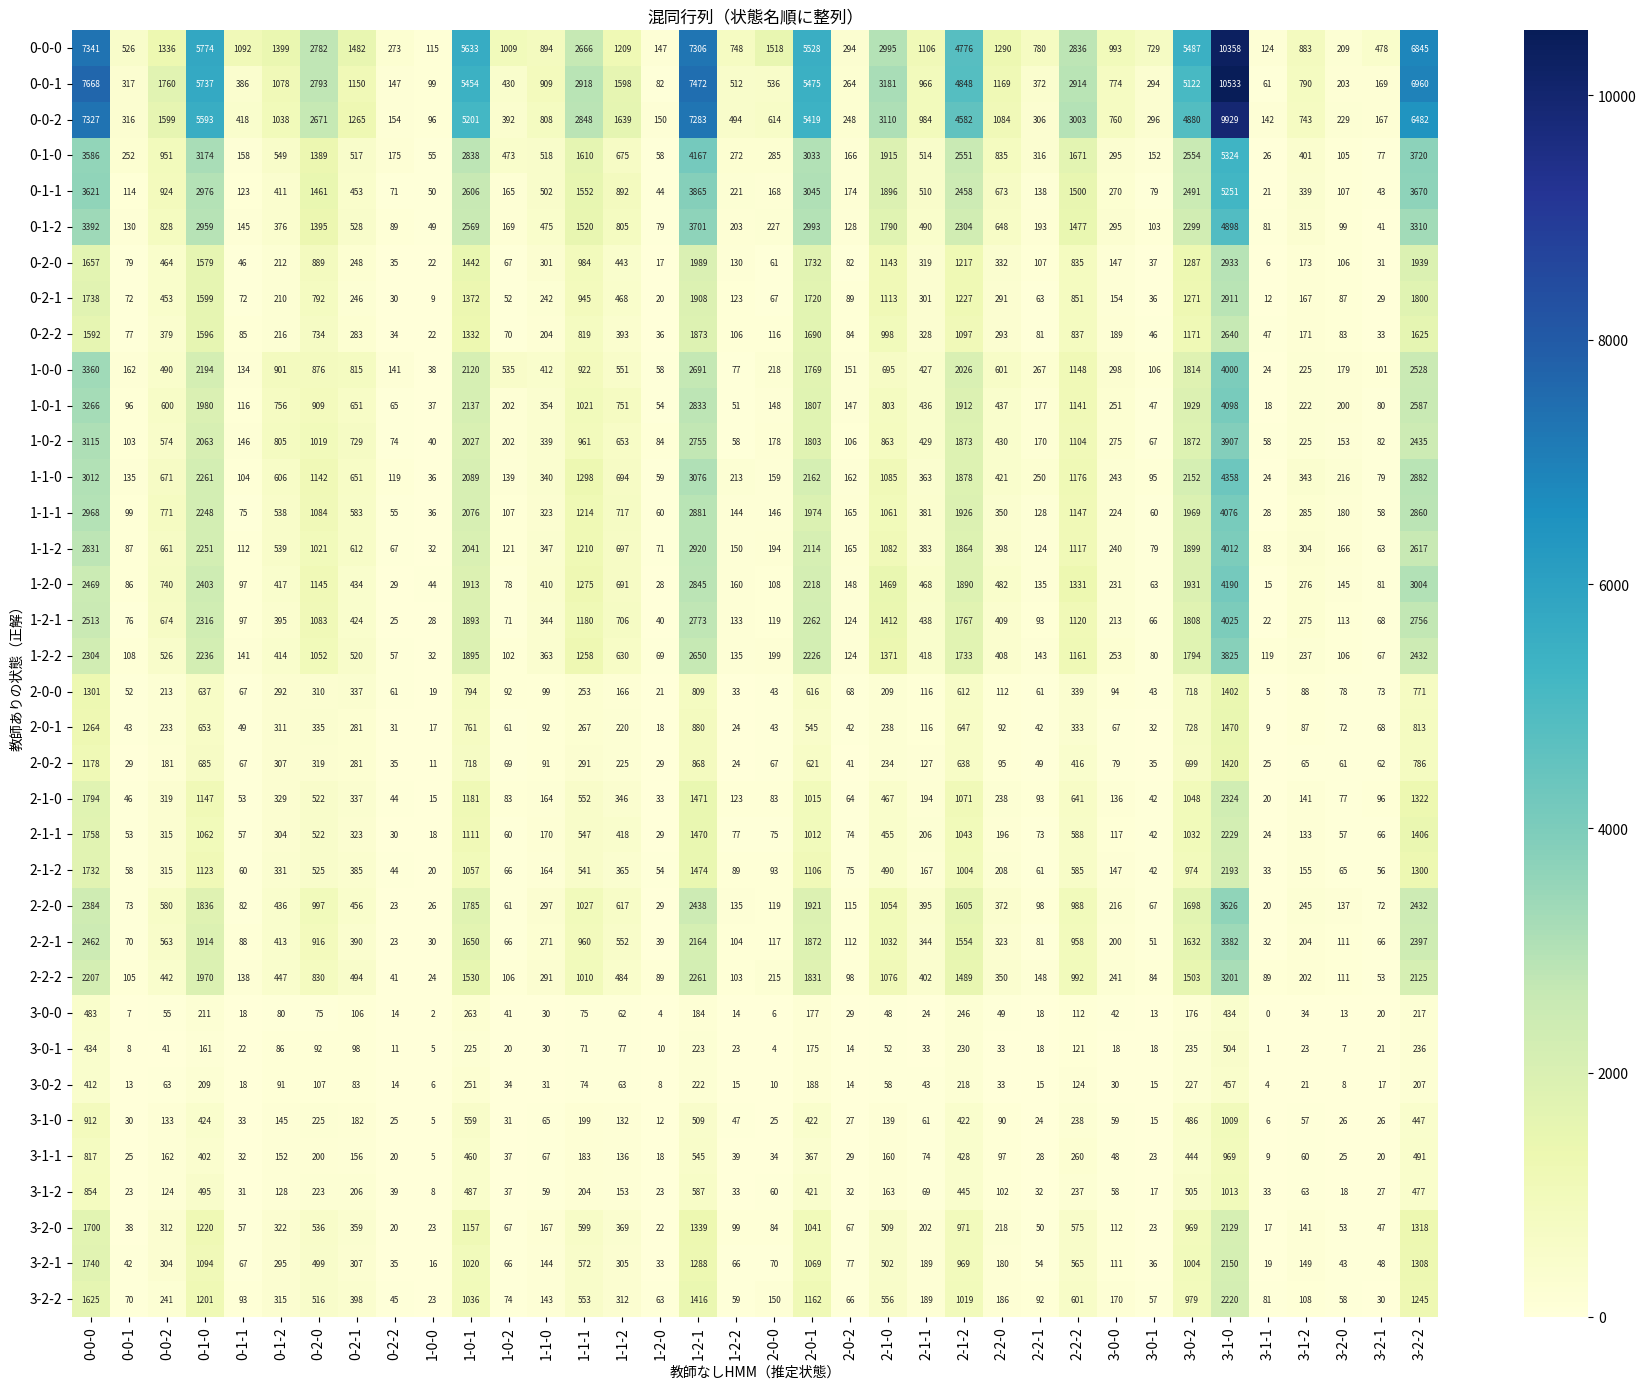

In [44]:
# ラベル（状態名）を取得
all_labels = situation_encoder.inverse_transform(np.arange(n_states))

# ラベル → インデックスの辞書
label_to_index = {label: i for i, label in enumerate(all_labels)}

# 正解順インデックス
true_idx_sorted = [label_to_index[label] for label in all_labels]

# mapping[pred] は整数なので、まず状態名に変換してから使う
mapped_labels = situation_encoder.inverse_transform([mapping[pred] for pred in col_ind])
pred_idx_sorted = [label_to_index[label] for label in mapped_labels]

# 並べ替えた混合行列
cm_ordered = cm[true_idx_sorted, :][:, pred_idx_sorted]

# 可視化
plt.figure(figsize=(18, 14))
sns.heatmap(cm_ordered, annot=True, fmt="d", cmap="YlGnBu",
            xticklabels=all_labels,
            yticklabels=all_labels,
            annot_kws={"size": 6})
plt.xlabel("教師なしHMM（推定状態）")
plt.ylabel("教師ありの状態（正解）")
plt.title("混同行列（状態名順に整列）")
plt.tight_layout()
plt.show()


In [45]:
from collections import Counter
print(Counter(pred_states))


Counter({30: 123400, 0: 88817, 16: 85136, 35: 79750, 3: 67383, 19: 64531, 10: 62683, 29: 58787, 23: 56540, 21: 35424, 26: 35042, 13: 34179, 6: 31986, 14: 19214, 2: 18997, 7: 16770, 5: 15644, 24: 13525, 22: 12212, 12: 10460, 32: 8350, 27: 8050, 18: 6359, 11: 5455, 17: 5037, 25: 4880, 4: 4579, 20: 3865, 33: 3706, 1: 3620, 28: 3090, 34: 2615, 8: 2195, 15: 1690, 31: 1338, 9: 1113})


In [ ]:
# 観測値の分布も見てみるといい
Counter(X_train.flatten())


Counter({56: 140308,
         40: 135071,
         17: 103791,
         43: 84100,
         41: 73779,
         55: 70675,
         3: 66800,
         47: 65376,
         42: 64245,
         4: 58874,
         28: 58729,
         46: 53726,
         44: 53703,
         48: 50966,
         16: 49473,
         39: 46508,
         50: 42223,
         30: 38757,
         27: 37201,
         45: 37147,
         29: 36588,
         64: 36330,
         51: 35272,
         60: 35051,
         63: 33252,
         54: 32966,
         61: 32629,
         49: 32419,
         34: 30641,
         53: 30101,
         1: 26338,
         35: 26055,
         24: 25982,
         31: 25453,
         59: 24335,
         25: 23758,
         33: 23573,
         14: 22780,
         62: 22632,
         21: 22095,
         11: 21900,
         32: 21183,
         10: 20750,
         37: 19662,
         57: 19330,
         26: 18130,
         20: 16777,
         23: 16773,
         22: 16654,
         38: 16640,


: 

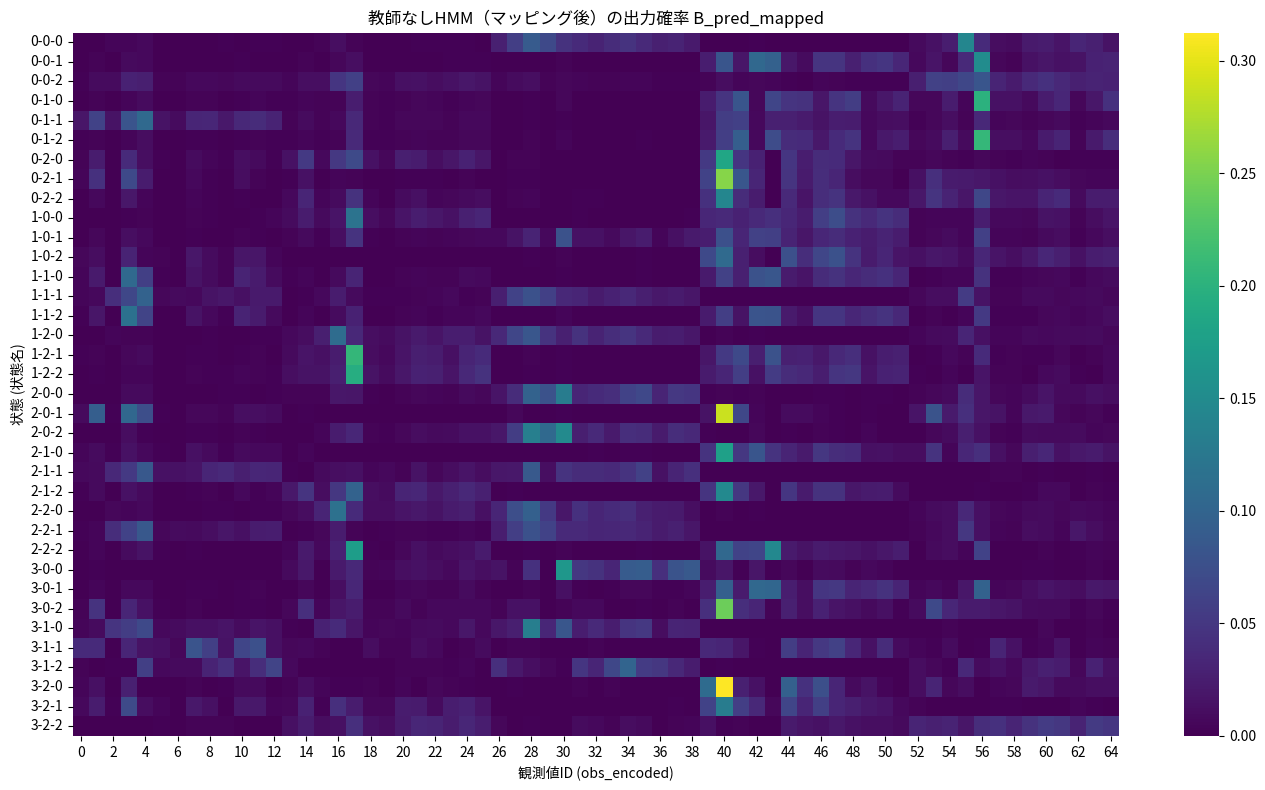

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 逆変換で状態名を復元（例: "win_same_early"）
state_labels = situation_encoder.inverse_transform(range(B_pred_mapped.shape[0]))

# DataFrame にしてラベルつける
df_b_pred = pd.DataFrame(B_pred_mapped, index=state_labels)

# ヒートマップ描画
plt.figure(figsize=(14, 8))
sns.heatmap(df_b_pred, cmap="viridis", annot=False, cbar=True)
plt.title("教師なしHMM（マッピング後）の出力確率 B_pred_mapped")
plt.xlabel("観測値ID (obs_encoded)")
plt.ylabel("状態 (状態名)")
plt.tight_layout()
plt.show()


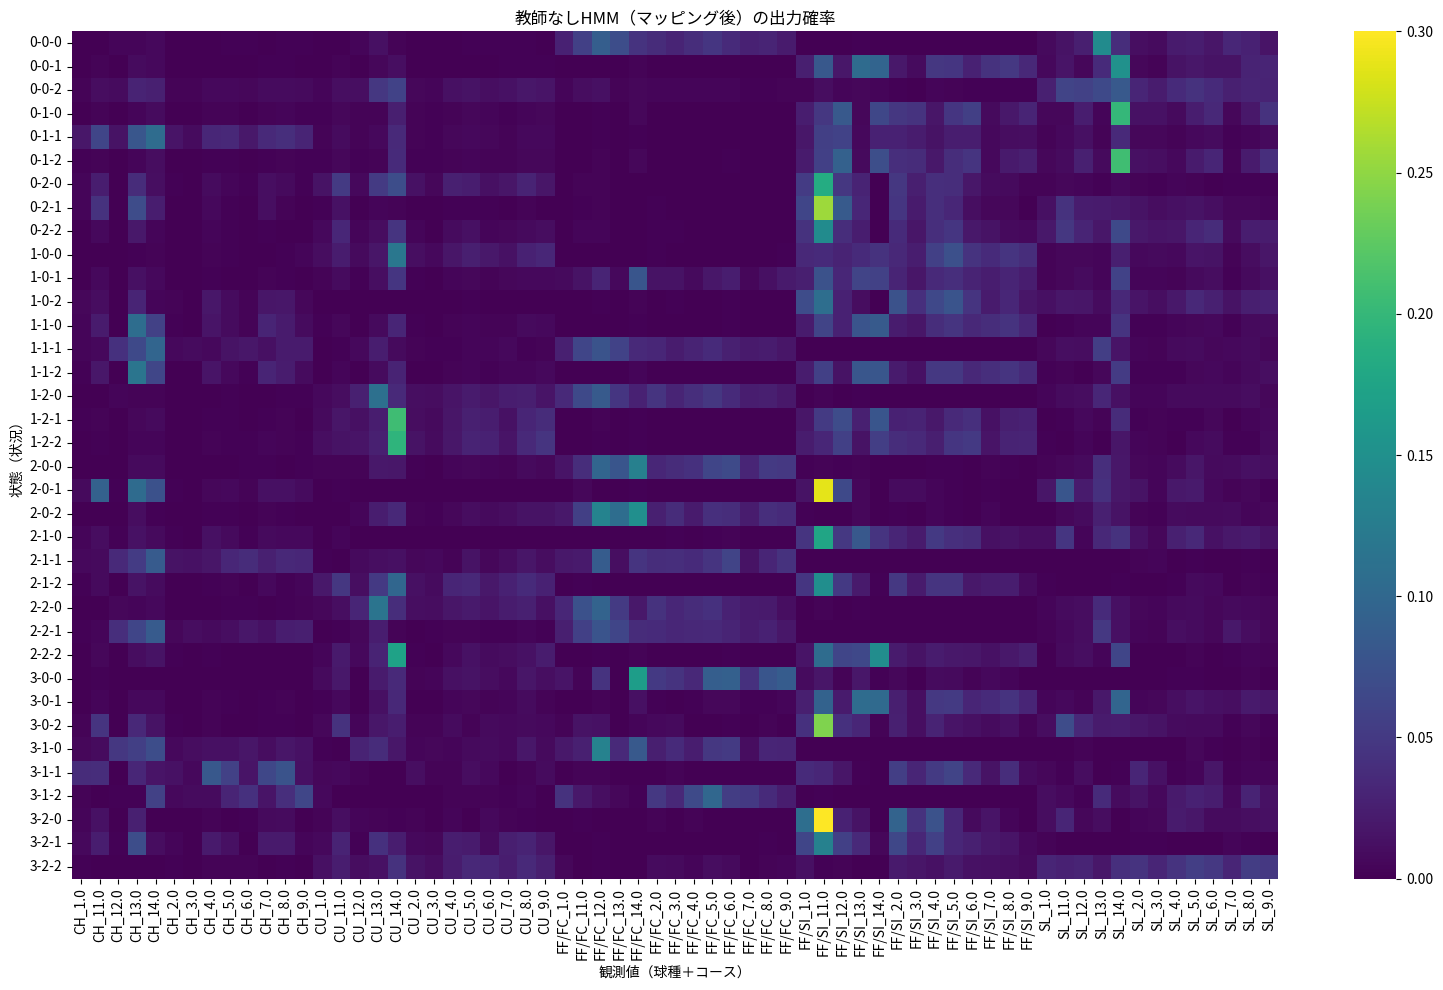

In [40]:
# obs_encodedを人間にわかる形に戻す
obs_labels = obs_encoder.inverse_transform(range(B_pred.shape[1]))

plt.figure(figsize=(16, 10))
sns.heatmap(
    pd.DataFrame(B_pred_mapped, index=state_labels, columns=obs_labels),
    cmap="viridis",
    annot=False,
    cbar=True,
    vmax=0.3
)
plt.title("教師なしHMM（マッピング後）の出力確率")
plt.xlabel("観測値（球種＋コース）")
plt.ylabel("状態（状況）")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [32]:
print("B_predのユニーク値:", np.unique(B_pred))
print("B_pred_mappedのユニーク値:", np.unique(B_pred_mapped))
print("B_predのshape:", B_pred.shape)
print("B_pred_mappedのshape:", B_pred_mapped.shape)


B_predのユニーク値: [3.75437174e-17 1.33902121e-15 5.05230425e-14 ... 2.56231813e-01
 2.88082384e-01 3.12505318e-01]
B_pred_mappedのユニーク値: [3.75437174e-17 1.33902121e-15 5.05230425e-14 ... 2.56231813e-01
 2.88082384e-01 3.12505318e-01]
B_predのshape: (36, 65)
B_pred_mappedのshape: (36, 65)


In [33]:
print("obs_encodedのユニーク数:", df["obs_encoded"].nunique())
print("X_trainのユニーク値:", np.unique(X_train))


obs_encodedのユニーク数: 65
X_trainのユニーク値: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]


In [34]:
print("mapping.keys():", list(mapping.keys()))
print("mapping.values():", list(mapping.values()))
print("B_pred.shape:", B_pred.shape)

# このインデックス指定がズレてないか確認
temp = B_pred[list(mapping.keys()), :]
print("temp.shape:", temp.shape)


mapping.keys(): [30, 0, 16, 3, 35, 19, 12, 24, 27, 5, 10, 7, 29, 2, 23, 26, 21, 13, 11, 33, 4, 34, 25, 32, 6, 14, 22, 8, 28, 9, 1, 15, 31, 17, 20, 18]
mapping.values(): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
B_pred.shape: (36, 65)
temp.shape: (36, 65)


In [35]:
from scipy.special import rel_entr
from scipy.stats import entropy

# KLダイバージェンス
def safe_kl(p, q, eps=1e-10):
    p = np.clip(p, eps, 1)
    q = np.clip(q, eps, 1)
    return np.sum(rel_entr(p, q))

kl_per_state = [safe_kl(B_true[i], B_pred_mapped[i]) for i in range(n_states)]
mean_kl = np.mean(kl_per_state)

# エントロピー（出力分布の曖昧さ）
entropies = [entropy(row + 1e-10) for row in B_pred_mapped]

# 表示
for i, (kl, ent) in enumerate(zip(kl_per_state, entropies)):
    print(f"状態 {i}: KL={kl:.4f}, Entropy={ent:.4f}")
print(f"\n▼ 平均KLダイバージェンス: {mean_kl:.5f}")


状態 0: KL=1.9692, Entropy=3.2543
状態 1: KL=0.9221, Entropy=3.1033
状態 2: KL=0.6476, Entropy=3.6209
状態 3: KL=0.7817, Entropy=3.1832
状態 4: KL=0.9163, Entropy=3.4998
状態 5: KL=0.7792, Entropy=3.1534
状態 6: KL=0.9188, Entropy=3.2820
状態 7: KL=1.0746, Entropy=3.0064
状態 8: KL=0.8049, Entropy=3.4353
状態 9: KL=1.1055, Entropy=3.4356
状態 10: KL=0.2737, Entropy=3.5955
状態 11: KL=1.1306, Entropy=3.3500
状態 12: KL=0.7470, Entropy=3.3389
状態 13: KL=3.7138, Entropy=3.4610
状態 14: KL=0.8055, Entropy=3.2700
状態 15: KL=1.4094, Entropy=3.4533
状態 16: KL=1.1018, Entropy=3.1967
状態 17: KL=1.1678, Entropy=3.2826
状態 18: KL=1.6760, Entropy=3.2664
状態 19: KL=1.9775, Entropy=2.6955
状態 20: KL=1.9200, Entropy=3.1759
状態 21: KL=1.2399, Entropy=3.2374
状態 22: KL=4.4710, Entropy=3.4053
状態 23: KL=1.5352, Entropy=3.2541
状態 24: KL=1.6085, Entropy=3.4242
状態 25: KL=4.5632, Entropy=3.4567
状態 26: KL=1.0284, Entropy=3.0224
状態 27: KL=1.9992, Entropy=3.0348
状態 28: KL=0.8959, Entropy=3.2978
状態 29: KL=1.1946, Entropy=3.2602
状態 30: KL=5.3285, En

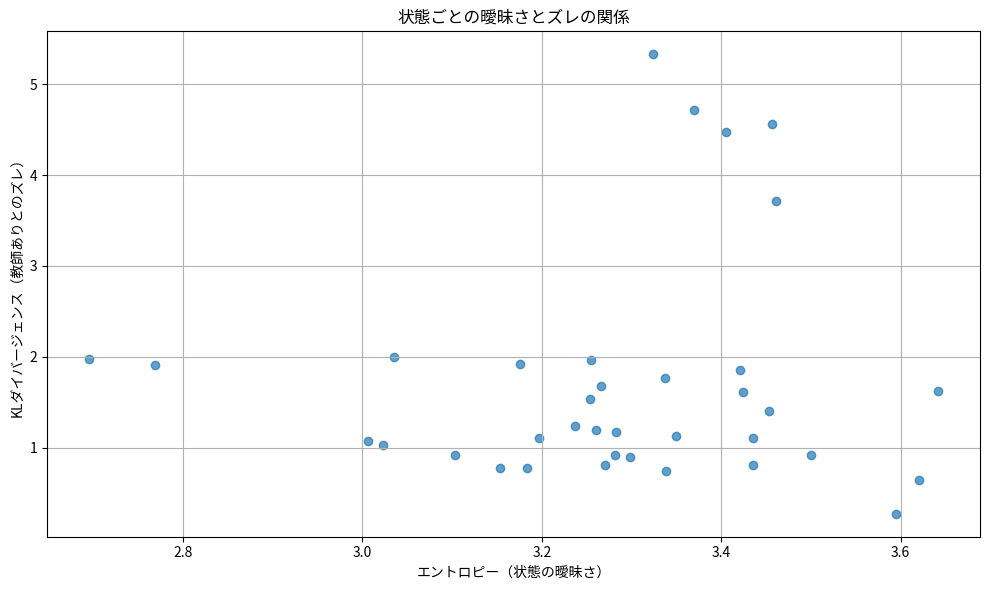

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(entropies, kl_per_state, alpha=0.7)
plt.xlabel("エントロピー（状態の曖昧さ）")
plt.ylabel("KLダイバージェンス（教師ありとのズレ）")
plt.title("状態ごとの曖昧さとズレの関係")
plt.grid(True)
plt.tight_layout()
plt.show()


In [37]:
一致閾値 = 0.3
matching_states = [i for i, kl in enumerate(kl_per_state) if kl < 一致閾値]
print(f"教師ありと一致した状態数: {len(matching_states)}")
print("状態番号:", matching_states)


教師ありと一致した状態数: 1
状態番号: [10]


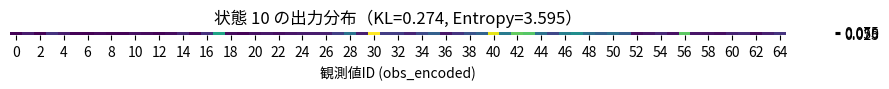

In [38]:
for s in matching_states:
    plt.figure(figsize=(10, 1))
    sns.heatmap([B_pred_mapped[s]], cmap="viridis", cbar=True)
    plt.title(f"状態 {s} の出力分布（KL={kl_per_state[s]:.3f}, Entropy={entropies[s]:.3f}）")
    plt.xlabel("観測値ID (obs_encoded)")
    plt.yticks([])
    plt.tight_layout()
    plt.show()


In [39]:
# 逆変換（状態名）を使う
for s in matching_states:
    print(f"状態 {s} = {situation_encoder.inverse_transform([s])[0]}")


状態 10 = 1-0-1
